In [50]:
import numpy as np
import os 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from python_files.maxent import MaxEnt
import python_files.densities as d
from scipy.stats import kstest

In [51]:
cwd = os.getcwd()
data = np.load(cwd+"/skewness_kurtosis/example_fields.npy")
print(data.shape) #19 images

(19, 256, 256)


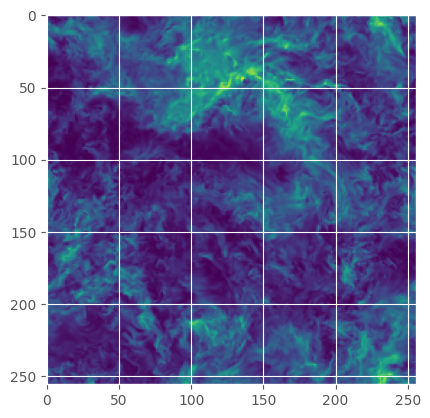

In [45]:

plt.imshow(data[5])
plt.show()

Max: 27.32 || Min: -0.82
Avg: 1.4e-09 || Var: 1.0000
Skewness: 7.33 || Kurtosis: 100.98


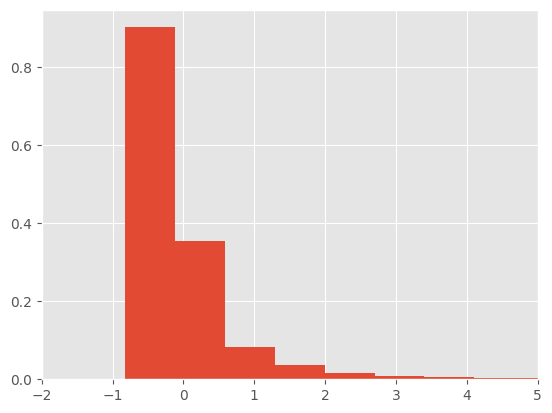

In [46]:
arr = data[2].flatten()
print(f"Max: {np.max(arr):.2f} || Min: {np.min(arr):.2f}")
print(f"Avg: {np.mean(arr):.1e} || Var: {np.var(arr):.4f}")
skew = np.mean(arr**3)
kurt = np.mean(arr**4)
print(f"Skewness: {skew:.2f} || Kurtosis: {kurt:.2f}")
plt.hist(arr, density=True, bins=40)
plt.xlim(-2,5)
plt.show()

Estimate of absolute integration error of norm. const.: 2.349e-08
The resulting parameters:
  Lambda_1 = -0.303
  Lambda_2 = -1.012
  Lambda_3 = 0.131
  Lambda_4 = -0.004


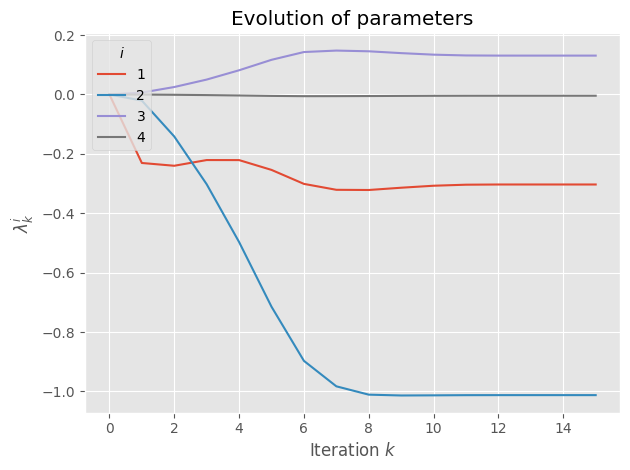

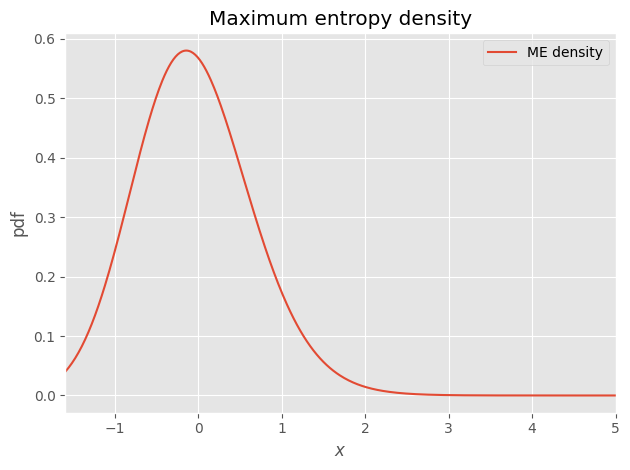

In [47]:
picture = data[0]
picture_flat = picture.flatten()
l = np.min(picture)
u = np.max(picture)+.1
skew = np.mean(arr**3)
kurt = np.mean(arr**4)
n = 150

ob_skewkurt = MaxEnt(support=(l,u),
                     n_quadrature=n,
                     b_constraints=d.b_constraint_skewkurt(skew,kurt),
                     f_vector=d.f_constraint_skewkurt)
ob_skewkurt._algorithm(k_max=200)
ob_skewkurt._visualize_algorithm()
ob_skewkurt._visualize_solution(xlim=(l,5))

0.9972440618906646


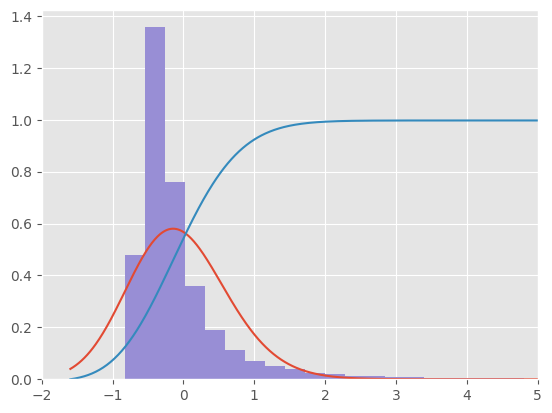

In [48]:
N=500
xx = np.linspace(l,5,N)

y = ob_skewkurt._p(xx)
yy = ob_skewkurt._cdf(xx)
print(yy[-1])
plt.plot(xx,y)
plt.plot(xx,yy)
plt.hist(arr, density=True, bins=100)
plt.xlim(-2,5)
plt.show()


In [49]:
    # a =([ob_skewkurt._cdf(x) for x in picture_flat])

res = kstest(picture_flat, ob_skewkurt._cdf)
print(res)

KeyboardInterrupt: 

In [ ]:
# print(min(a),max(a))

In [52]:
def one_rejection_sample(density, xlim, C):
    while(True):
        Y = np.random.uniform(*xlim)
        U = np.random.uniform()
        if(U <= (xlim[1]-xlim[0])*density(Y)/C):
            return Y

def rejection_sampling(size, density, xlim):
    """Univariate rvs, on closed support [a,b]
    - density should be vectorizable"""
    #determine C
    N = 1000
    xx = np.linspace(*xlim,N)
    yy = density(xx)
    C = np.max(yy)*(xlim[1]-xlim[0])

    results = np.zeros(size)
    for i in range(size):
        results[i] = one_rejection_sample(density, xlim, C)
    return results



In [53]:
def standardize_image(image):
    mean = np.mean(image)
    var = np.var(image)
    return (image-mean)/np.sqrt(var)

def generate_copy_image(image_raw, 
                        i,
                        extra_upper_l=0.01, 
                        n=150, 
                        u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt(skew,kurt),
                        f_vector=d.f_constraint_skewkurt)
    ob_skewkurt._algorithm(k_max=200, message_norm=False)
    # ob_skewkurt._visualize_algorithm()
    ob_skewkurt._visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt._p, 
                                   xlim=(l,u))

    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title(f"Raw image {i}")
    ax[0].grid()
    
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    res_sample = kstest(image_flat, sample_ME)
    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].legend()

    plt.tight_layout()
    plt.savefig(f"skewness_kurtosis/generated_copy_example_{i}.pdf")
    plt.show()

    res = kstest(image_flat, ob_skewkurt._cdf)
    print(f"p-value of KS-test on _cdf and real sample: {res.pvalue:.3e}")
    print(f"p-value of KS-test on simulated and real sample: {res_sample.pvalue:.3e}")

def generate_copy_image_6(image_raw, extra_upper_l=0.01, n=150, u_show=None):
    
    image = standardize_image(image_raw)
    image_flat = image.flatten()

    l = np.min(image)
    u = np.max(image) + extra_upper_l

    if(u_show == None):
        u_show = u

    skew = np.mean(image_flat**3)
    kurt = np.mean(image_flat**4)
    moment_6 = np.mean(image_flat**6)

    ob_skewkurt = MaxEnt(support=(l,u),
                        n_quadrature=n,
                        b_constraints=d.b_constraint_skewkurt_6(skew,
                                                                kurt,
                                                                moment_6),
                        f_vector=d.f_constraint_skewkurt_6)
    ob_skewkurt._algorithm(k_max=200, message_norm=False)
    # ob_skewkurt._visualize_algorithm()
    ob_skewkurt._visualize_solution(xlim=(l,5))


    #sample from ME distribution
    n_sample = image_flat.size
    sample_ME = rejection_sampling(size=n_sample, 
                                   density=ob_skewkurt._p, 
                                   xlim=(l,u))

    fig, ax = plt.subplots(2,1)
    ax[0].imshow(image_raw)

    ax[0].set_title("Raw image")
    ax[0].grid()
    
    n_breaks = 50
    bins = np.linspace(l, u_show, n_breaks)
    ax[1].hist(image_flat, density=True, bins=bins, alpha=0.6, label="Real")
    ax[1].hist(sample_ME,  density=True, bins=bins, alpha=0.6, label="Sampled")

    res_sample = kstest(image_flat, sample_ME)
    ax[1].set_title(f"Histogram of pixel values ($p$-val. KS: {res_sample.pvalue:.1e})")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Density")
    ax[1].set_xlim(l, u_show)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    res = kstest(image_flat, ob_skewkurt._cdf)
    print(f"p-value of KS-test on _cdf and real sample: {res.pvalue:.3e}")
    print(f"p-value of KS-test on simulated and real sample: {res_sample.pvalue:.3e}")

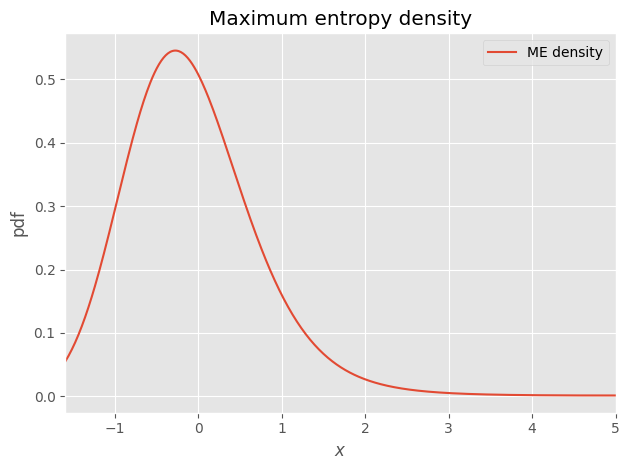

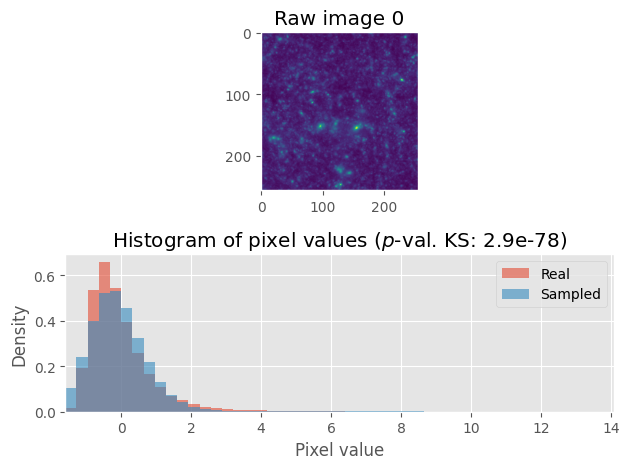

p-value of KS-test on _cdf and real sample: 2.349e-172
p-value of KS-test on simulated and real sample: 2.865e-78


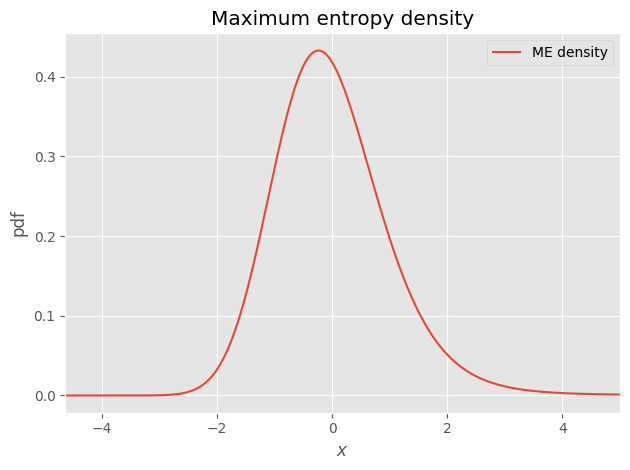

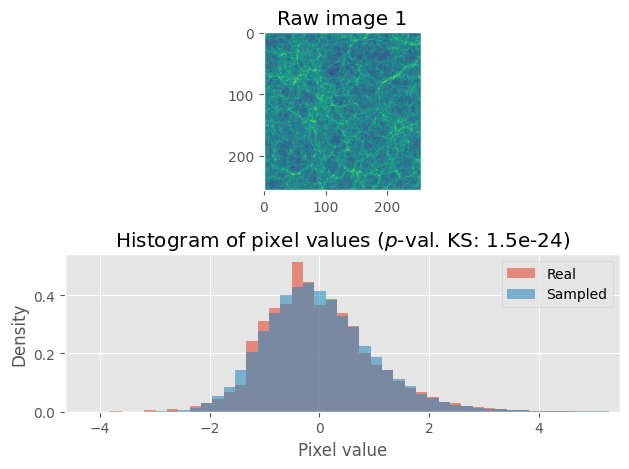

p-value of KS-test on _cdf and real sample: 2.131e-57
p-value of KS-test on simulated and real sample: 1.545e-24


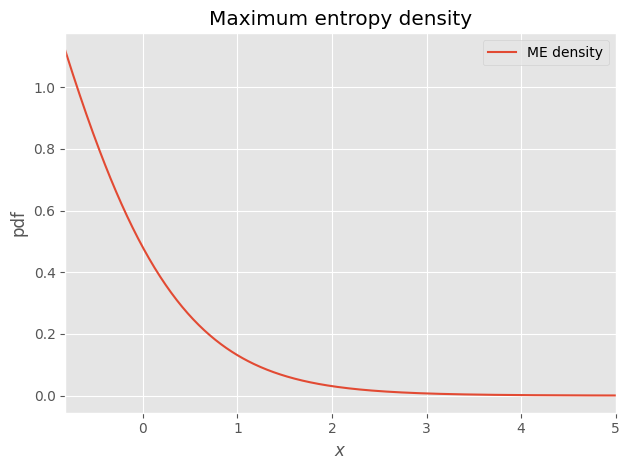

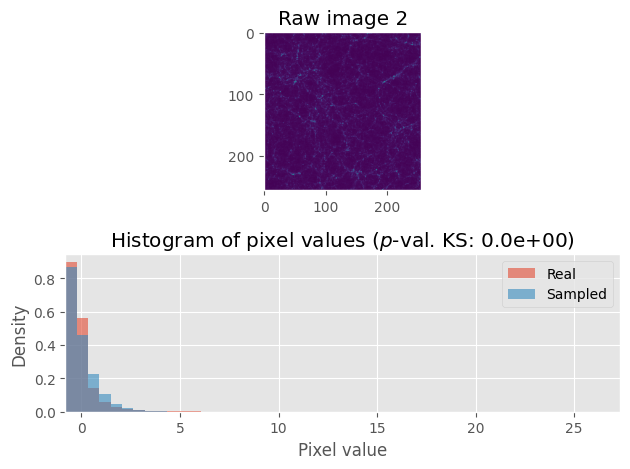

p-value of KS-test on _cdf and real sample: 0.000e+00
p-value of KS-test on simulated and real sample: 0.000e+00


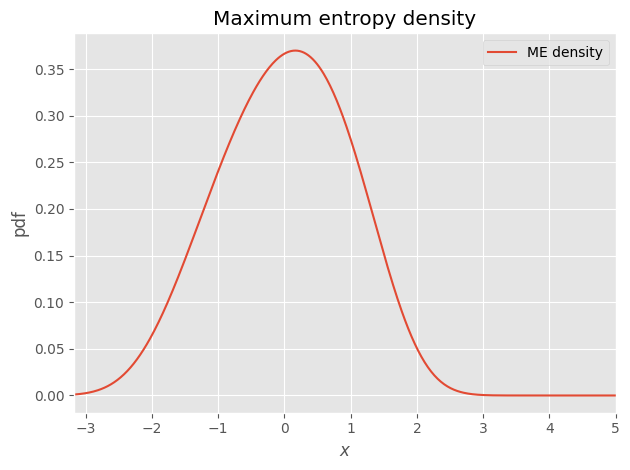

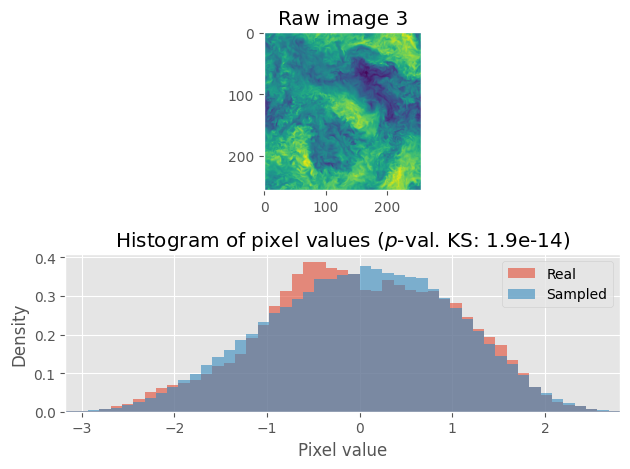

p-value of KS-test on _cdf and real sample: 4.875e-23
p-value of KS-test on simulated and real sample: 1.920e-14


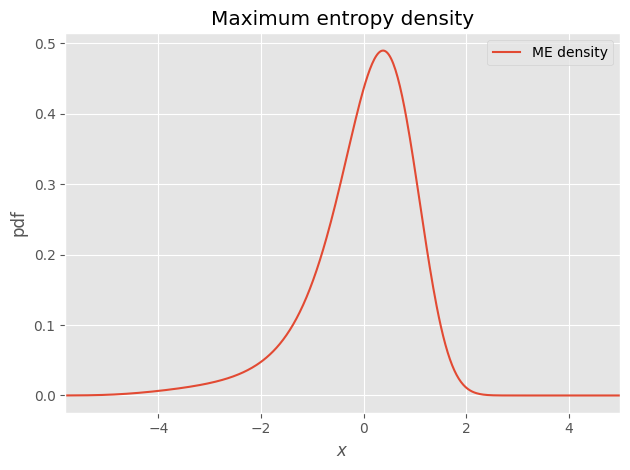

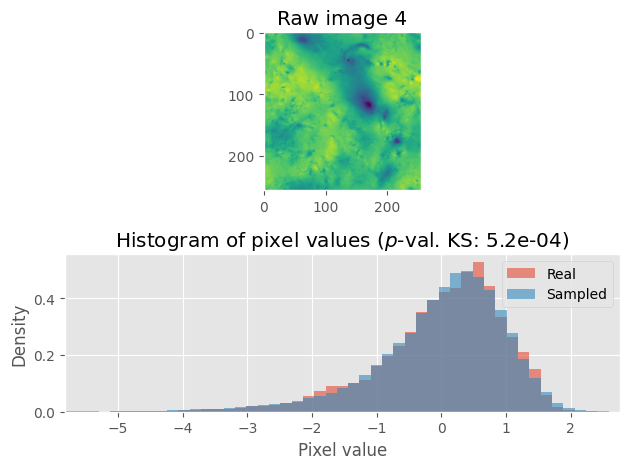

p-value of KS-test on _cdf and real sample: 6.668e-12
p-value of KS-test on simulated and real sample: 5.221e-04


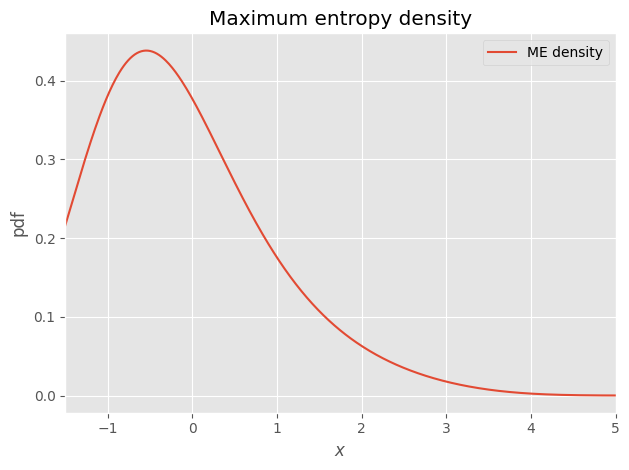

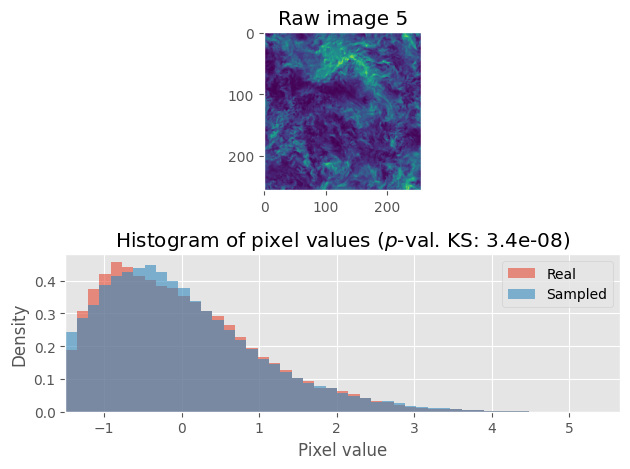

p-value of KS-test on _cdf and real sample: 2.173e-09
p-value of KS-test on simulated and real sample: 3.449e-08


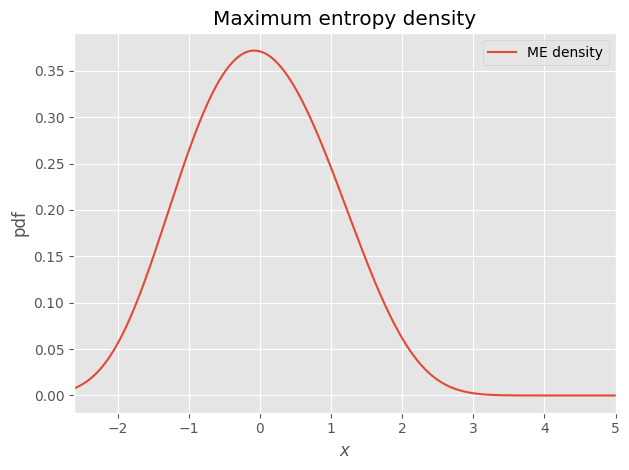

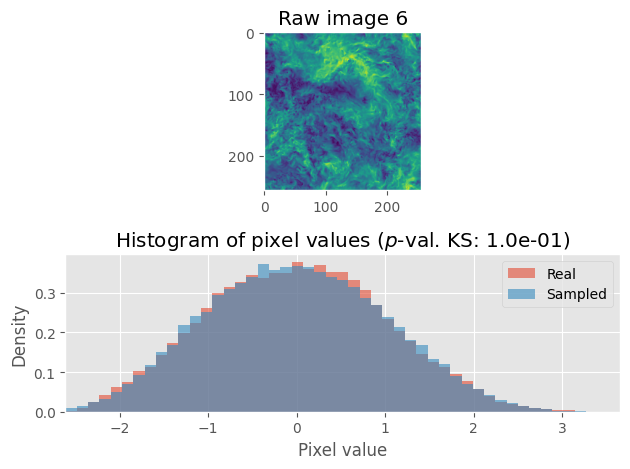

p-value of KS-test on _cdf and real sample: 4.285e-03
p-value of KS-test on simulated and real sample: 1.038e-01


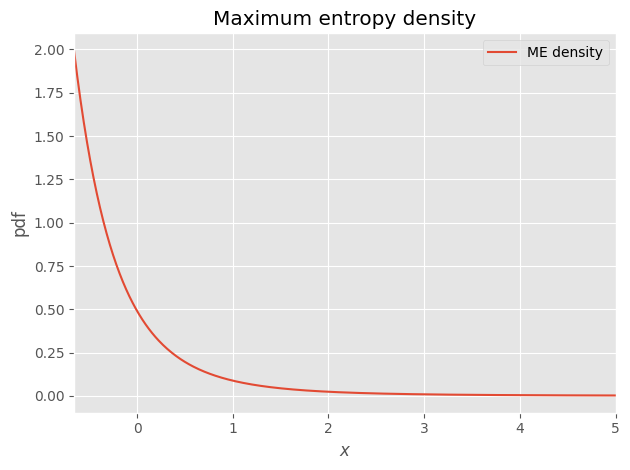

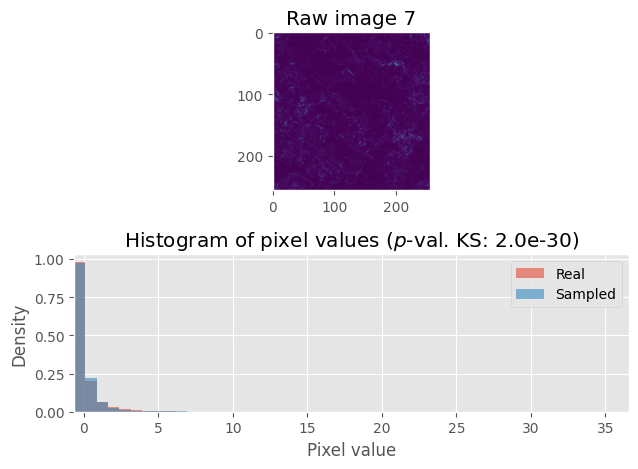

p-value of KS-test on _cdf and real sample: 5.166e-56
p-value of KS-test on simulated and real sample: 2.015e-30


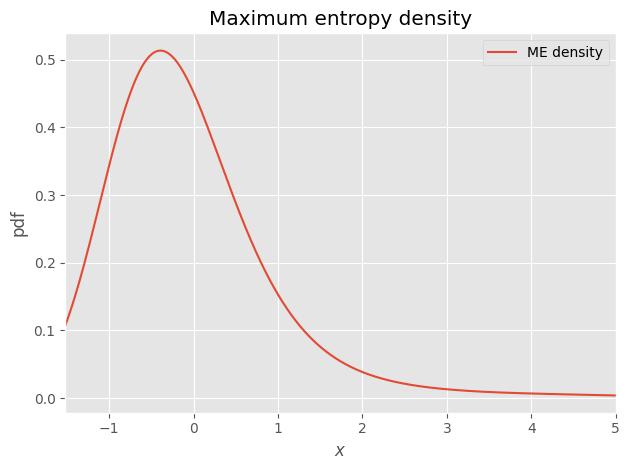

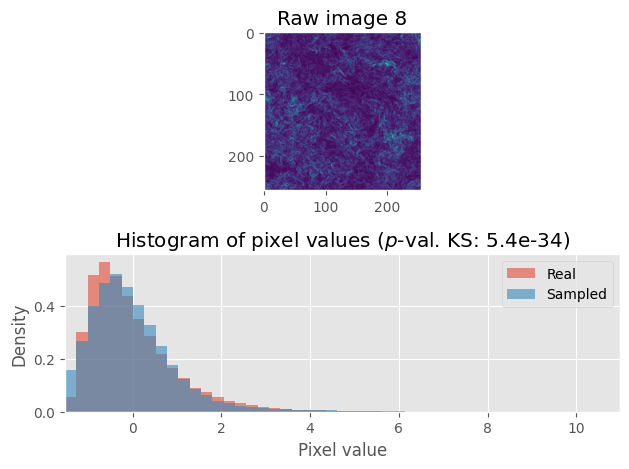

p-value of KS-test on _cdf and real sample: 2.237e-65
p-value of KS-test on simulated and real sample: 5.424e-34


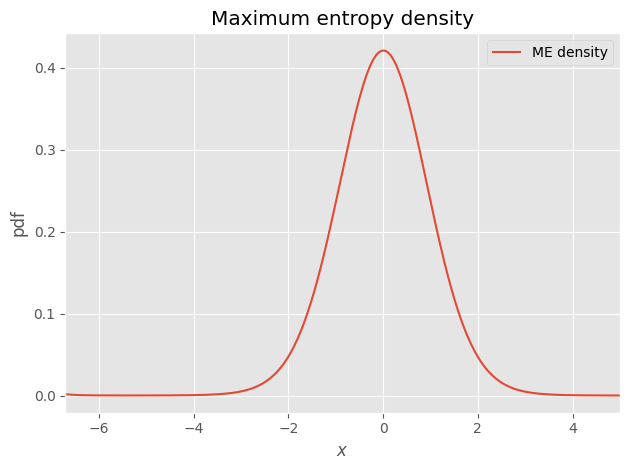

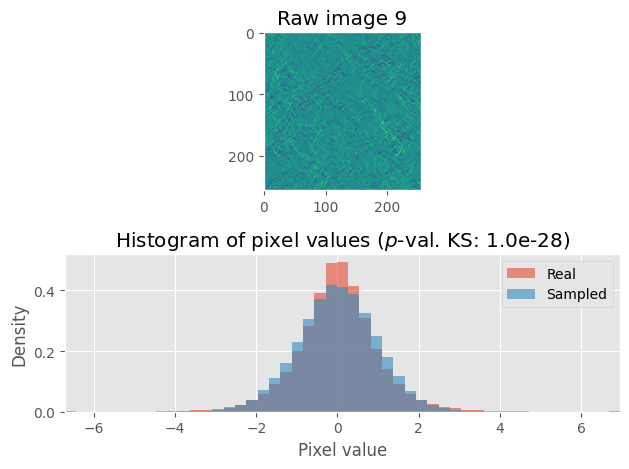

p-value of KS-test on _cdf and real sample: 2.124e-51
p-value of KS-test on simulated and real sample: 1.001e-28


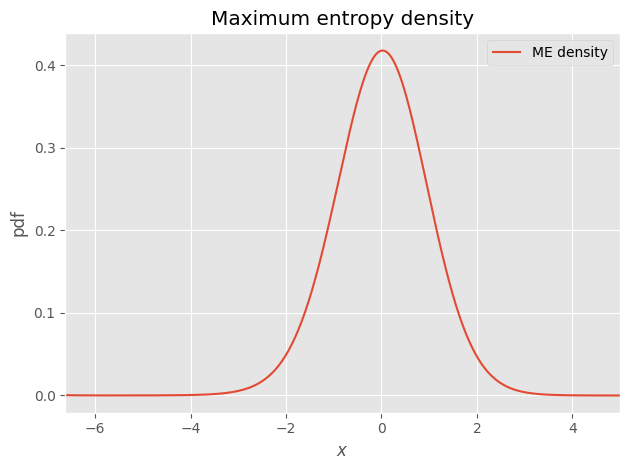

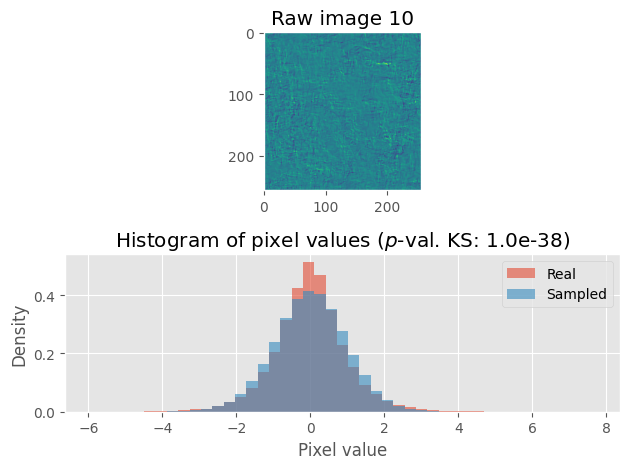

p-value of KS-test on _cdf and real sample: 1.671e-79
p-value of KS-test on simulated and real sample: 1.031e-38


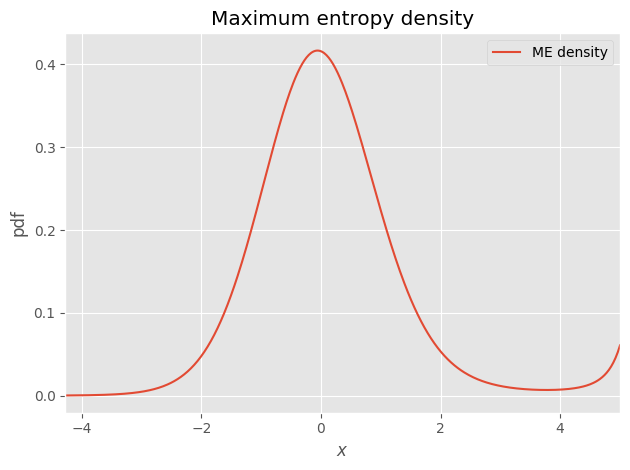

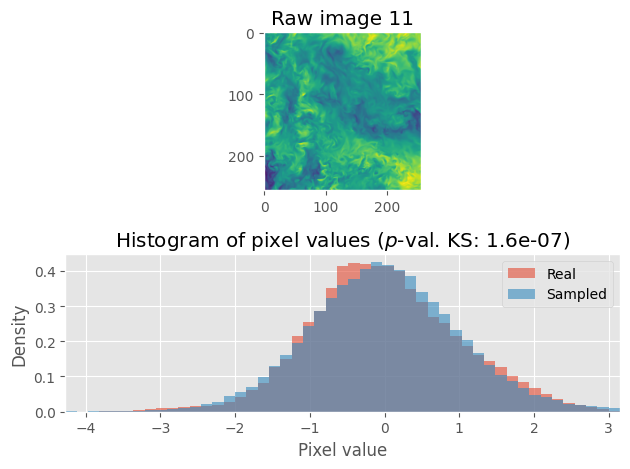

p-value of KS-test on _cdf and real sample: 1.364e-13
p-value of KS-test on simulated and real sample: 1.575e-07


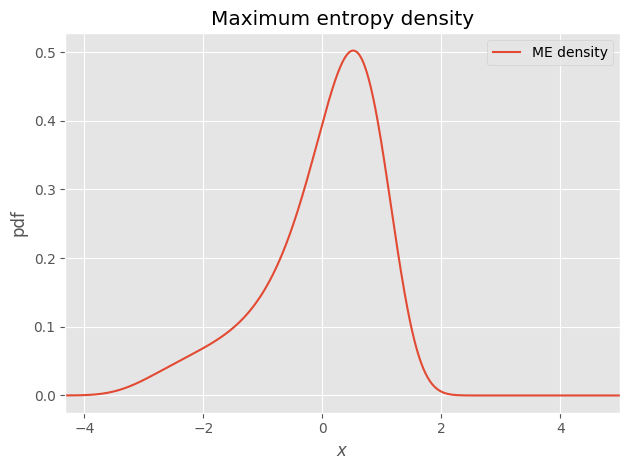

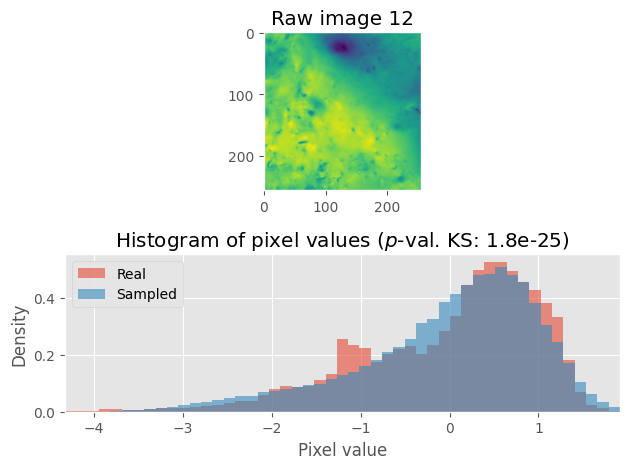

p-value of KS-test on _cdf and real sample: 6.314e-56
p-value of KS-test on simulated and real sample: 1.754e-25


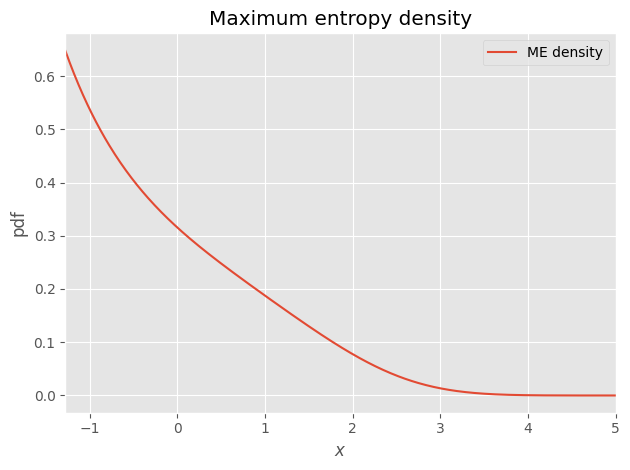

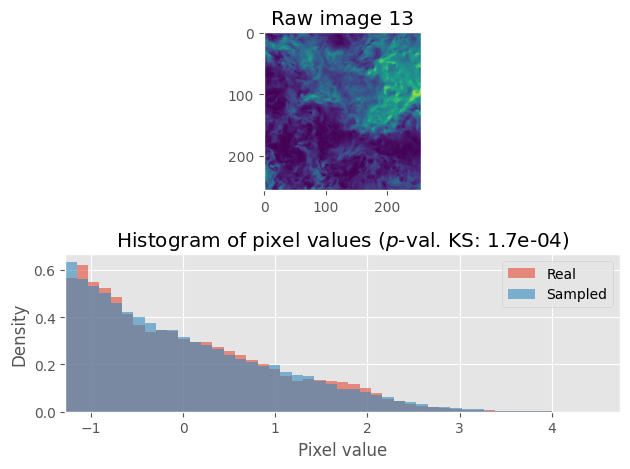

p-value of KS-test on _cdf and real sample: 2.466e-07
p-value of KS-test on simulated and real sample: 1.717e-04


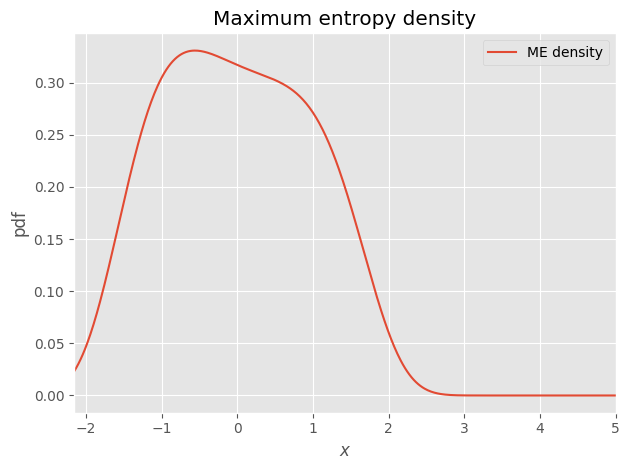

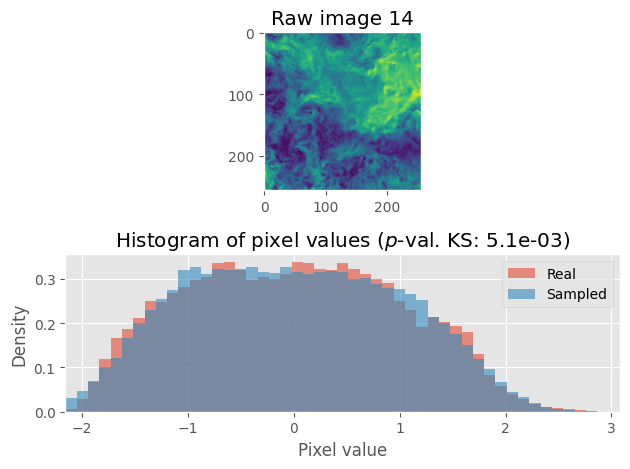

p-value of KS-test on _cdf and real sample: 2.164e-05
p-value of KS-test on simulated and real sample: 5.124e-03


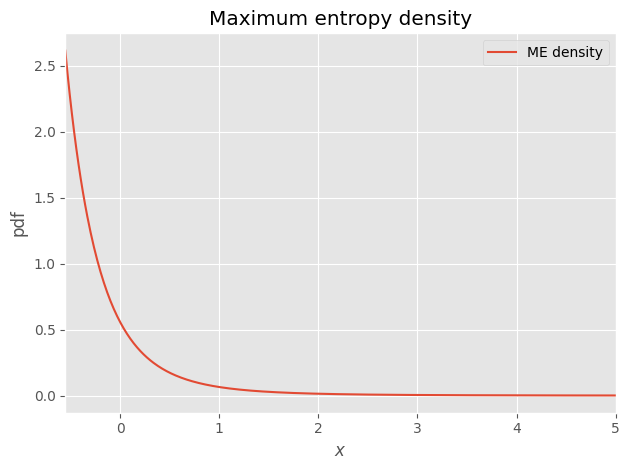

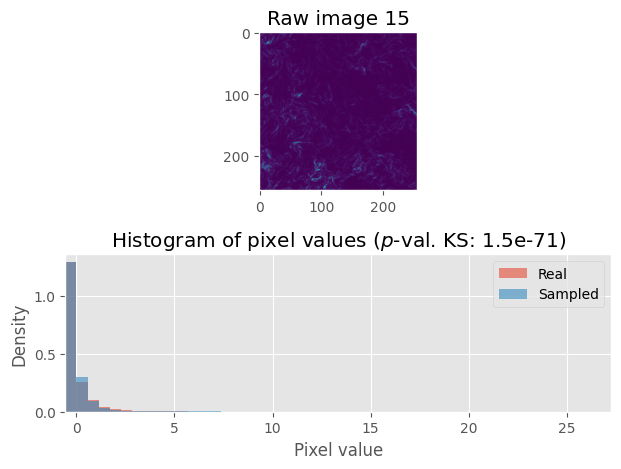

p-value of KS-test on _cdf and real sample: 2.277e-136
p-value of KS-test on simulated and real sample: 1.482e-71


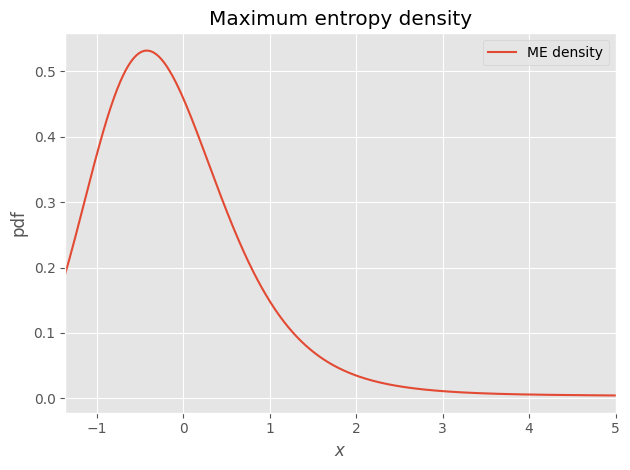

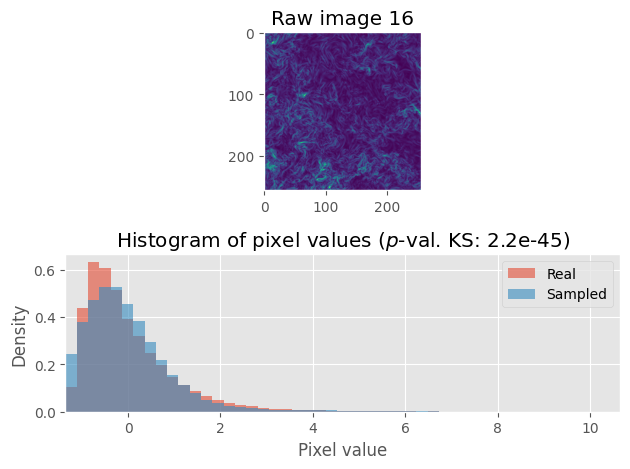

p-value of KS-test on _cdf and real sample: 1.679e-91
p-value of KS-test on simulated and real sample: 2.182e-45


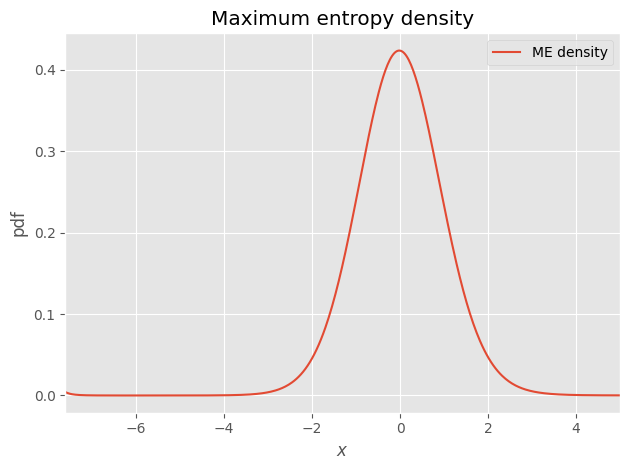

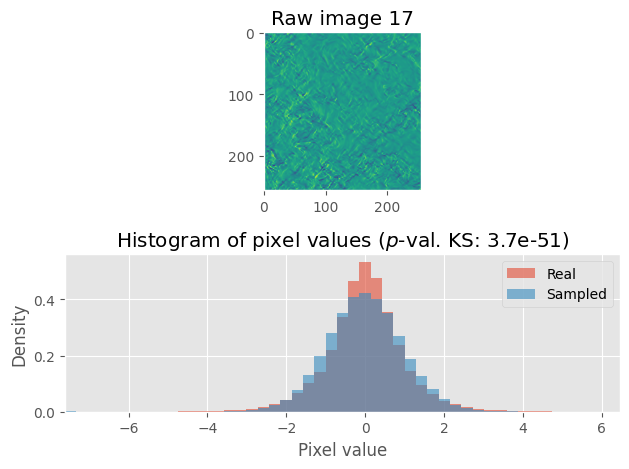

p-value of KS-test on _cdf and real sample: 9.185e-104
p-value of KS-test on simulated and real sample: 3.707e-51


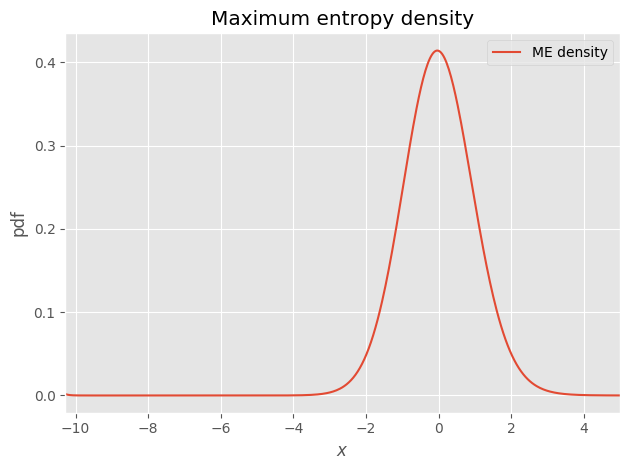

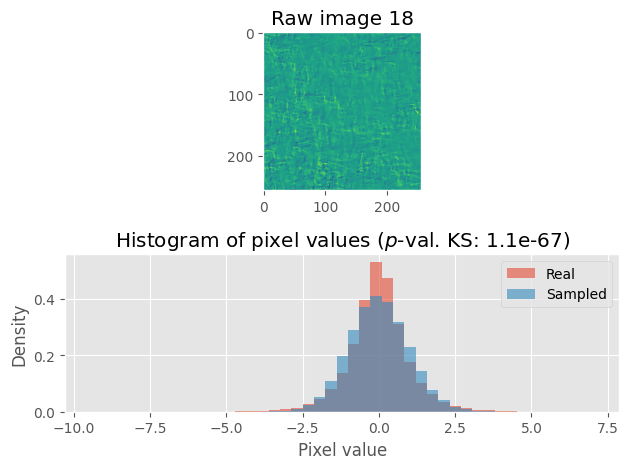

p-value of KS-test on _cdf and real sample: 1.799e-122
p-value of KS-test on simulated and real sample: 1.067e-67


In [54]:
for i,image in enumerate(data):
    generate_copy_image(image,
                        i,
                        extra_upper_l=0, 
                        n=150)

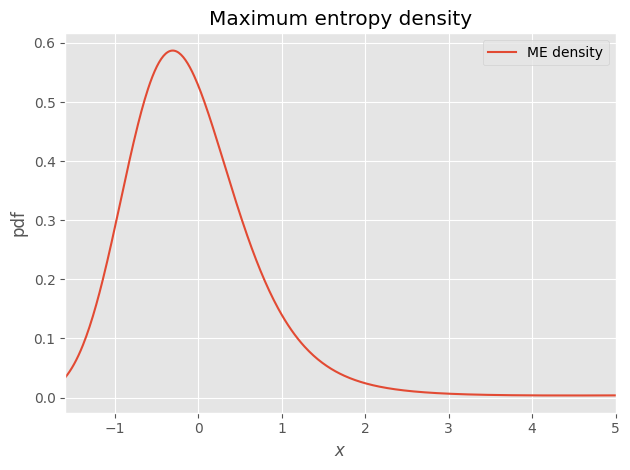

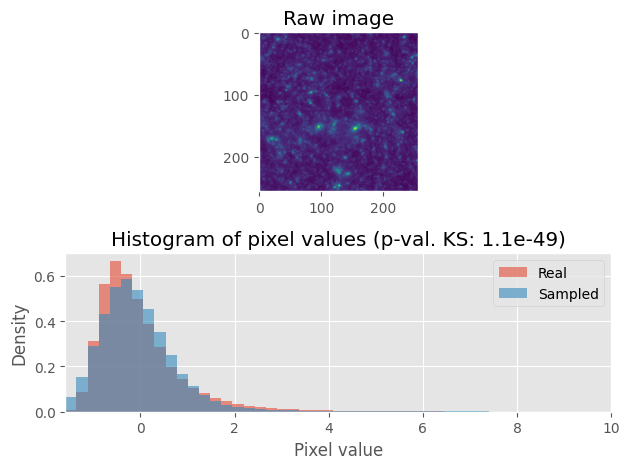

p-value of KS-test on _cdf and real sample: 1.121e-110
p-value of KS-test on simulated and real sample: 1.062e-49


In [ ]:
generate_copy_image_6(data[0], 
                    extra_upper_l=0.1, 
                    n=150,
                    u_show=10)